## Using auto-encoder for anomaly detection with a large number of variables

### Load data and packages

In [5]:
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime 
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
processed_data_path = "/Users/az02234/Documents/Projet_AC/AnomalyDetectionAndLIME/data/processed/"

In [7]:
# Put the data here 
df_numeric = pd.read_csv(processed_data_path+"df_numeric.csv")
df_anomaly = pd.read_csv(processed_data_path+"df_anomaly.csv")

### Data preprocessing

In [8]:
# From pandas dataframe to array
df_anomaly_array = np.array(df_anomaly)
print(df_anomaly.shape)

(44842, 102)


In [9]:
# Remove invariant array
list_invariant_array = []
for c in range(df_anomaly_array.shape[1]):
    if df_anomaly_array[:,c].std()==0:
        list_invariant_array.append(c)
df_anomaly_array = np.delete(df_anomaly_array, list_invariant_array, 1)

In [10]:
# Normalize data by removing mean and dividing by standard deviation
cols_mean = []
cols_std = []
for c in range(df_anomaly_array.shape[1]):
    cols_mean.append(df_anomaly_array[:,c].mean())
    cols_std.append(df_anomaly_array[:,c].std())
    df_anomaly_array[:, c] = (df_anomaly_array[:, c] - cols_mean[-1]) / cols_std[-1]

### Train auto-encoder

#### Set parameters

In [17]:
# Parameters
learning_rate = 0.001
training_epochs = 301
batch_size = 256
display_step = 20
 
# Network Parameters
n_hidden_1 = 15 # 1st layer num features
n_hidden_2 = 8 # 2nd layer num features
n_input = df_anomaly_array.shape[1] # number of columns of df_anomaly here as our feature dimension

#### Build neural network model

In [18]:
# Set variable for input data
X = tf.placeholder("float", [None, n_input])
 
# Setting variables for bias and weight
weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b2': tf.Variable(tf.random_normal([n_input])),
}

# Building the encoder
def encoder(x):
    # Encoder Hidden layer with tanh activation #1
    layer_1 = tf.nn.tanh(tf.add(tf.matmul(x, weights['encoder_h1']), biases['encoder_b1']))
    # Encoder Hidden layer with tanh activation #2
    layer_2 = tf.nn.tanh(tf.add(tf.matmul(layer_1, weights['encoder_h2']), biases['encoder_b2']))
    return layer_2
 
# Building the decoder
def decoder(x):
    # Decoder Hidden layer with tanh activation #1
    layer_1 = tf.nn.tanh(tf.add(tf.matmul(x, weights['decoder_h1']), biases['decoder_b1']))
    # Decoder Hidden layer with tanh activation #2
    layer_2 = tf.nn.tanh(tf.add(tf.matmul(layer_1, weights['decoder_h2']), biases['decoder_b2']))
    return layer_2
 
# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)
 
# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X
 
# Define batch mse
batch_mse = tf.reduce_mean(tf.pow(y_true - y_pred, 2), 1)
 
# Define raw error layer
batch_error_layer = y_true - y_pred
 
# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

#### Train neural network

Epoch: 0001 cost by batch= 1.601939797 Total cost 1.640231490 Time elapsed= 0:00:00.593034
Epoch: 0021 cost by batch= 4.025578499 Total cost 0.984571159 Time elapsed= 0:00:08.244440
Epoch: 0041 cost by batch= 0.548508763 Total cost 0.944427013 Time elapsed= 0:00:15.816697
Epoch: 0061 cost by batch= 0.929337502 Total cost 0.932870924 Time elapsed= 0:00:23.295508
Epoch: 0081 cost by batch= 0.180308998 Total cost 0.917328238 Time elapsed= 0:00:30.869195
Epoch: 0101 cost by batch= 0.134807184 Total cost 0.904805481 Time elapsed= 0:00:38.275296
Epoch: 0121 cost by batch= 1.794776201 Total cost 0.883902609 Time elapsed= 0:00:45.881977
Epoch: 0141 cost by batch= 0.463929176 Total cost 0.882456899 Time elapsed= 0:00:53.336539
Epoch: 0161 cost by batch= 0.165341109 Total cost 0.881340921 Time elapsed= 0:01:00.780946
Epoch: 0181 cost by batch= 0.478031725 Total cost 0.880533099 Time elapsed= 0:01:07.151727
Epoch: 0201 cost by batch= 1.024337292 Total cost 0.871120632 Time elapsed= 0:01:13.521396

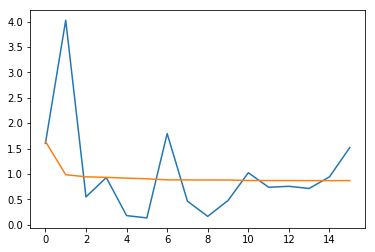

In [19]:
# TRAIN STARTS
save_model = '/Users/az02234/Documents/Projet_AC/Data_SMACC/temp_saved_model_1layer.ckpt'
saver = tf.train.Saver()

# Initializing the variables
init = tf.global_variables_initializer()

total_error_sequence = []
batch_error_sequence = []

with tf.Session() as sess:
    now = datetime.now()
    sess.run(init)
    total_batch = int(df_anomaly_array.shape[0]/batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_idx = np.random.choice(df_anomaly_array.shape[0], batch_size)
            batch_xs = df_anomaly_array[batch_idx]
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
            
        # Display logs per epoch step
        if epoch % display_step == 0:
            totalcost = sess.run(cost, feed_dict={X: df_anomaly_array})
            print("Epoch:", '%04d' % (epoch+1),
                  "cost by batch=", "{:.9f}".format(c), 
                  "Total cost {:.9f}".format(totalcost),
                  "Time elapsed=", "{}".format(datetime.now() - now))
            batch_error_sequence.append(c)
            total_error_sequence.append(totalcost)

    print("Optimization Finished!")
    
    save_path = saver.save(sess, save_model)
    print("Model saved in file: {}".format(save_path))

    
error_series = pd.Series(batch_error_sequence)
error_series.plot()

error_series = pd.Series(total_error_sequence)
error_series.plot()

#### Extract anomalies and explain them

In [22]:
with tf.Session() as sess:
    now = datetime.now()
    saver.restore(sess, save_model)
    
    # return anomaly
    anomalies = sess.run(batch_mse, feed_dict={X: df_anomaly_array[0:100]})
    
print(anomalies[0:10])

INFO:tensorflow:Restoring parameters from /Users/az02234/Documents/Projet_AC/Data_SMACC/temp_saved_model_1layer.ckpt
[0.00633878 0.00587993 0.00588043 0.00588628 0.00587728 0.0058761
 0.00587347 0.00587414 0.00587864 0.00595542]


Number of observations:  (44842,)
Minimum anomaly value:  9.431222e-05
Maximum anomaly value:  833.42554
Mean anomaly value:  0.8695386648178101
How the data look: 
 0    0.006475
1    0.006397
2    0.006382
3    0.006364
4    0.006410
dtype: float32


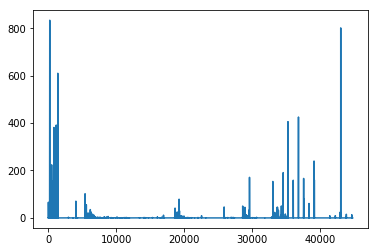

In [17]:
anomaly_series = pd.Series(anomalies)
print("Number of observations: ", anomaly_series.shape)
print("Minimum anomaly value: ", anomaly_series.min())
print("Maximum anomaly value: ", anomaly_series.max())
print("Mean anomaly value: ",anomaly_series.mean())
print("How the data look: \n", anomaly_series.head())
anomaly_series.plot()

In [34]:
# classify anomaly
anomaly_rate = 0.05
anomalies_df = pd.DataFrame(anomalies, columns=["anomaly_index"])
anomalies_df = anomalies_df.sort_values(by="anomaly_index")
anomalies_df["anomaly"] = 0
anomalies_df.iloc[round(anomalies_df.shape[0]*(1-anomaly_rate)):, 1]=1

In [38]:
print(anomalies_df.describe())
print("95th percentile", anomalies_df.anomaly_index.quantile(0.95))
print("99th percentile", anomalies_df.anomaly_index.quantile(0.99))

       anomaly_index       anomaly
count   44842.000000  44842.000000
mean        0.869702      0.049998
std        13.175756      0.217943
min         0.000094      0.000000
25%         0.000243      0.000000
50%         0.001386      0.000000
75%         0.005266      0.000000
max       833.425537      1.000000
95th percentile 0.40714628994464386
99th percentile 14.232559251784448
